## Extracting ATP production from standard Wave software output XLSX file
251030 written by Brennan Wadsworth

- The purpose of this script is to take the pH readings, the oxygen consumption rate (OCR) values, and the extracellular acidification rate (ECAR) values in order to calculate the ATP production in pmol/min specific to glycolysis versus oxidative phosphorylation (OXPHOS). The protocol to produce the required data is described in the Randall Johnson Laboratory SOP "KI_SOP_Seahorse for ATP Production Calculation", which is based on the publication from Desousa et al. (2023) EMBO Reports 24(10).

- This script expects the standard Wave software output file with the following sheet names: Assay Configuration, Rate, Rate (columns), Rate (plates), Raw, Calibration, and Operation Log. The script will use the "Rate" and "Raw" sheets for data collection, so it is best for these to not be modified. 
    - You SHOULD modify the assay configuration sheet, changing the cells in the protocol summary to the right of "calibration". The standard is for these to say "Injection 1", "Injection 2" ..., ensure that these cells instead name the injection, e.g. "Oligomycin".



### Notes on assumptions for the protocol used

- The standard protocol associated with this assay is media supplemented with glucose, glutamine, and pyruvate for the experimental and background correction wells. It is required that these wells are treated with oligomycin and Rotenone+Antimycin A, the other injections do not matter.
    - The script will look through the Assay Configuration sheet to find which injection was oligomycin and which was Rot+AA. If they are left unlabelled the script will assume that Oligomycin is the first injection and Rot+AA the third injection.
    - This script will assume that whatever measurements precede the oligomycin injection represents "basal" metabolism
- The script will scan the Assay Configuration sheet to look for the acid treatment wells. The standard name for these wells should be "Buffering Power H2SO4" or "Buffering Power HCl", but the script will check for anything with H2SO4, HCL, acid, or buffer in the name and assign those wells to the buffering power calculation. If none are found a standard buffering power value will be assumed.
- The script will scan the Assay Configuration sheet and find groups and organize the resultant data according to groups, with a calculation made for each well.

In [ ]:
# !jupyter nbconvert --to python main.ipynb 

[NbConvertApp] Converting notebook main.ipynb to python
[NbConvertApp] Writing 18254 bytes to main.py


In [ ]:
# Install required packages with:

# pip install -r requirements.txt

# To update requirements.txt with currently installed packages, run:

# pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import numpy as np

Note the directory for storage of excel files

In [ ]:
# directory for storing excel sheets
data_dir = "data"
files = [f for f in os.listdir(data_dir) if not f.startswith('.') and not f.startswith('~') and f.endswith('xlsx')]
print(files)
use_file = 0  # change this index to use a different file from the data directory
run_acid = 1
print("reading file:", files[use_file])

res_dir = "results"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)


['practice.xlsx', '251003_PM LPS_r2HB.xlsx', '251031_PM RAW_LPS IFNg_S2HB BCATIN2.xlsx', '251010_PM LPS_S2HB.xlsx', '251003_PM LPS_S2HB.xlsx', '251031_PM RAW_LPS IFNg_S2HB BCATIN2_plate2.xlsx']
reading file: 251031_PM RAW_LPS IFNg_S2HB BCATIN2.xlsx


Begin extracting data and required protocol information

In [5]:
# Read assay configuration, rate, and raw data sheets from the excel file
assay_conf = pd.read_excel(os.path.join(data_dir, files[use_file]), sheet_name="Assay Configuration")
rate = pd.read_excel(os.path.join(data_dir, files[use_file]), sheet_name="Rate")
raw = pd.read_excel(os.path.join(data_dir, files[use_file]), sheet_name="Raw")

In [7]:
# Extract plate layout and groups from assay configuration
plate_idx = assay_conf.index[assay_conf.iloc[:,0] == "Group Layout"].to_list()
plate_layout = assay_conf.iloc[plate_idx[0]+1:plate_idx[0]+9,2:14]
plate_layout.columns = np.arange(1, 13).tolist()

groups=plate_layout.melt().value.unique().tolist()
print(groups)

['Buffering Power-XF DMEM Control-PM1', 'Background', 'LPS IFNg-XF DMEM Control-PM1', 'LPS IFNg-XF DMEM + 500 uM S2HB-PM1', 'LPS IFNg-XF DMEM + 10 uM BCAT-IN-2-PM1', 'LPS IFNg-XF DMEM Control-PM2', 'LPS IFNg-XF DMEM + 500 uM S2HB-PM2', 'LPS IFNg-XF DMEM + 10 uM BCAT-IN-2-PM2', 'LPS IFNg-XF DMEM Control-PM3', 'LPS IFNg-XF DMEM + 500 uM S2HB-PM3', 'LPS IFNg-XF DMEM + 10 uM BCAT-IN-2-PM3', 'LPS IFNg-XF DMEM Control-RAW', 'LPS IFNg-XF DMEM + 500 uM S2HB-RAW', 'LPS IFNg-XF DMEM + 10 uM BCAT-IN-2-RAW', 'Control-XF DMEM Control-RAW', 'Control-XF DMEM + 500 uM S2HB-RAW', 'Control-XF DMEM + 10 uM BCAT-IN-2-RAW']


In [8]:
# extract protocol information and oligomycin and rotenone/antimycin A injection times
prot_idx = assay_conf.index[assay_conf.iloc[:,0] == "Protocol Summary"].to_list()
protocol = assay_conf.iloc[prot_idx[0]+1:prot_idx[0]+8, 2:7]

cycle_counts = protocol.iloc[5, :].astype(str).str[-1].astype(int)
injections = protocol.iloc[0,:].tolist()

oligomycin = [s for s in injections if "oligo" in s.lower()]
if oligomycin == []:
    oligomycin = [injections[2]]
print("The following will be used as the oligomycin injection:", oligomycin)
rot_aa = [s for s in injections if "rot" in s.lower() or "antimy" in s.lower()]
if rot_aa == []:
    rot_aa = [injections[4]]
print("The following will be used as the rotenone/antimycin A injection:", rot_aa)

protocol_df = pd.DataFrame(zip(injections, cycle_counts), columns=["Injection", "Cycle Count"]).set_index("Injection")
protocol_df["cycle_end"] = protocol_df["Cycle Count"].cumsum()
protocol_df["cycle_start"] = protocol_df["cycle_end"] - protocol_df["Cycle Count"] + 1
protocol_df

The following will be used as the oligomycin injection: ['Oligo']
The following will be used as the rotenone/antimycin A injection: ['Rot+AA']


,Cycle Count,cycle_end,cycle_start
Injection,,,
Baseline,3,3,1
LPS+IFNg,8,11,4
Oligo,3,14,12
FCCP,3,17,15
Rot+AA,2,19,18


In [ ]:
if run_acid:

    # check groups for sulfuric acid and hydrochloric acid controls
    sulfuric_acid_ctrl = [g for g in groups if "sul" in str(g).lower() or "h2so4" in str(g).lower()]
    hydrochloric_acid_ctrl = [g for g in groups if "hcl" in str(g).lower()]

    if sulfuric_acid_ctrl != []:
        print(f"The following groups appear to be sulfuric acid controls: {sulfuric_acid_ctrl}")
    if hydrochloric_acid_ctrl != []:
        print(f"The following groups appear to be hydrochloric acid controls: {hydrochloric_acid_ctrl}")
    if sulfuric_acid_ctrl == [] and hydrochloric_acid_ctrl == []:
        sulfuric_acid_ctrl = [g for g in groups if "buff" in str(g).lower() or "acid" in str(g).lower()]
        print(f"The following groups will be used as sulfuric acid controls: {sulfuric_acid_ctrl}")
    else:
        sulfuric_acid_ctrl = []
        run_acid = 0
        print("No sulfuric acid controls detected. Standard buffering power of 0.28939800915432956 will be used.")


The following groups will be used as sulfuric acid controls: ['Buffering Power-XF DMEM Control-PM1']


## Begin calculations
### Acid and ECAR calculations

251031 notes - initially thought we just take the basal pH reading and then compare against that, but I think what we are meant to do is to compare the pH reading on either side of an injection. The final 5 in the measurement cycle before injection and the final 5 in the measurement cycle after injection. We should double check that this is what they did in Desousa.

No, Desousa has it as we initially thought, the final measurement cycle against the original baseline. So, it is just the long 8 cycle LPS stim that is messing with things.

In [11]:
if run_acid:

    # calculating buffering power. For each buffering power well calculate the average pH reading from the final 5 readings prior to any injection
    raw_df = raw.loc[raw.Group == sulfuric_acid_ctrl[0], ["pH", "Measurement", "Tick", "Well", "Group"]]
    basal_pH_cycle = protocol_df.iloc[0, 1]
    print("collecting basal pH reading from cycle:", basal_pH_cycle)

    # Calculate average pH for the last 5 measurements per well at the basal cycle
    basal_pH_by_well = (raw_df.loc[raw_df.Measurement == basal_pH_cycle]
                        .groupby('Well')
                        .apply(lambda x: x.tail(5)['pH'].mean())
                        .to_dict())


collecting basal pH reading from cycle: 3


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_2428/3910092647.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.tail(5)['pH'].mean())


In [ ]:
if run_acid:
    # Calculate the change in pH compared with the basal pH for each buffering power well using the final 5 readings of each final measurement cycle per injection
    # Store results in a dataframe
    results_list = []
    valid_acid = 1
    try:
        for injection, cycle_end in protocol_df['cycle_end'].items():
            # Calculate mean pH for the last 5 measurements of this cycle for each well
            injection_pH_by_well = (raw_df.loc[raw_df.Measurement == cycle_end]
                                .groupby('Well')
                                .apply(lambda x: x.tail(5)['pH'].mean())
                                .to_dict())
            
            # Create DataFrame rows for this injection
            for well, ph in injection_pH_by_well.items():
                delta_pH = ph - basal_pH_by_well[well]
                results_list.append({
                    'Injection': injection,
                    'Well': well,
                    'pH': ph,
                    'Basal_pH': basal_pH_by_well[well],
                    'ΔpH': delta_pH
                })

        # Convert list of dictionaries to DataFrame
        results_df = pd.DataFrame(results_list)

        # Display the results
        results_df.to_csv(os.path.join(res_dir, f"{files[use_file]}_delta_pH_results.csv"), index=False)
        print(f"ΔpH results saved to CSV {files[use_file]}_delta_pH_results.csv in {res_dir}.")
    except KeyError as e:
        valid_acid = 0
        print("Error calculating ΔpH results:", e)

ΔpH results saved to CSV 251031_PM RAW_LPS IFNg_S2HB BCATIN2.xlsx_delta_pH_results.csv in results.


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_2428/2073112096.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.tail(5)['pH'].mean())
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_2428/2073112096.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.tail(5)['pH'].mean())
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_2428/2073112096.py:10: 

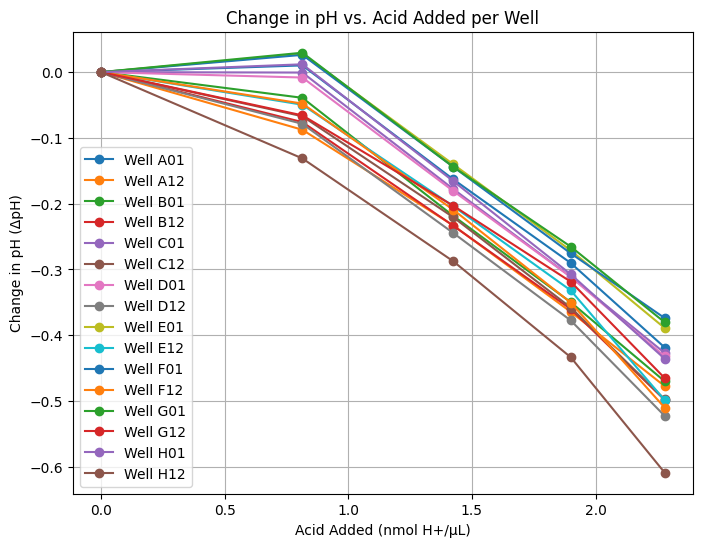

In [14]:
# Plot the change in pH against the amount of acid added per well.
# The standard protocol adds 62.5 nmol H+ per injection. We set baseline (injections[0]) to 0,
# and for subsequent injections multiply 62.5 by the injection index (0-based).
import matplotlib.pyplot as plt

if valid_acid and run_acid:
    # Build a mapping from injection name to 0-based injection index
    injection_index = {inj: idx for idx, inj in enumerate(injections)}

    # Compute acid added per injection for each row: 62.5 nmol * injection_index (baseline -> 0)
    results_df['Acid_Added_nmol'] = results_df['Injection'].map(injection_index).fillna(0).astype(int) * 62.5

    # convert nmol H+ to nmol/μL: volume begins at 150 μL and increases by 25 μL per injection
    results_df['Volume_uL'] = 150 + results_df['Injection'].map(injection_index).fillna(0).astype(int) * 25
    results_df['Acid_Added_nmol_per_uL'] = 2.28 * (results_df['Acid_Added_nmol'] / results_df['Volume_uL'])

    plt.figure(figsize=(8, 6))
    for well in results_df['Well'].unique():
        well_data = results_df[results_df['Well'] == well]
        plt.plot(well_data['Acid_Added_nmol_per_uL'], well_data['ΔpH'], marker='o', label=f'Well {well}')
    plt.xlabel('Acid Added (nmol H+/μL)')
    plt.ylabel('Change in pH (ΔpH)')
    plt.title('Change in pH vs. Acid Added per Well')
    plt.legend()
    plt.grid()
    plt.savefig(os.path.join(res_dir, f"{files[use_file]}_buffering_power_plot.png"))
    plt.show()

In [15]:
# Linear regression to extract slope (buffering power) for each well
# First, we need to check if the cycle count for the first injection is longer than standard (i.e., >3)
# If yes, we will ignore the baseline measurement cycles for buffering power calculation
if valid_acid and run_acid:
    buffering_power = {}
    for well in results_df['Well'].unique():
        well_data = results_df[results_df['Well'] == well]
        # Exclude baseline cycle if first injection cycle count > 3
        if protocol_df.iloc[1, 0] > 3:
            well_data = well_data[well_data['Injection'] != injections[0]]
        # Perform linear regression (1st degree polynomial fit)
        slope, intercept = np.polyfit(well_data['Acid_Added_nmol_per_uL'], well_data['ΔpH'], 1)
        buffering_power[well] = abs(slope)  # slope is ΔpH per nmol H+. This is equal to ΔmpH per pmol H+.

In [16]:
# Convert ECAR from mpH/min to pmol H+/min.
# Experimental ECAR and OCR data are in the rate dataframe
# Calculate the average of the last two ECAR measurements prior to oligomycin injection for each experimental well ("Group" is not buffering power or background)
#     Divide this by the average buffering power to yield the proton production rate in pmol H+/min.

# average buffering power across all buffering power wells
if valid_acid and run_acid:
    avg_buffering_power = np.mean(list(buffering_power.values()))
    print("Average buffering power (ΔpH per nmol H+):", avg_buffering_power)
else:
    avg_buffering_power = 0.28939800915432956  # default value if no valid acid control is present
    print("Using default average buffering power (ΔpH per nmol H+):", avg_buffering_power)

ecar_pmol = {}
for well in rate['Well'].unique():
    well_data = rate[rate['Well'] == well]
    # Get the last two ECAR measurements prior to oligomycin injection
    ecar_last_two = well_data[well_data['Measurement'] <= protocol_df.loc[oligomycin[0], "cycle_start"]-1]['ECAR'][-2:]
    ecar_pmol[well] = ecar_last_two.mean() / avg_buffering_power  # Average of the last two measurements

print("\nProton production rates (pmol H+/min) by well calculated from ECAR using cycle numbers:", protocol_df.loc[oligomycin[0], "cycle_start"]-2, protocol_df.loc[oligomycin[0], "cycle_start"]-1)

Average buffering power (ΔpH per nmol H+): 0.28939800915432956

Proton production rates (pmol H+/min) by well calculated from ECAR using cycle numbers: 10 11


### OCR Calculations

In [17]:
# We need to calculate the untreated oxygen consumption rate (OCR) for each well using the average of the last two OCR measurements prior to oligomycin injection
ocr_pmol = {}
for well in rate['Well'].unique():
    well_data = rate[rate['Well'] == well]
    # Get the last two OCR measurements prior to oligomycin injection
    ocr_last_two = well_data[well_data['Measurement'] <= protocol_df.loc[oligomycin[0], "cycle_start"]-1]['OCR'][-2:]
    ocr_pmol[well] = ocr_last_two.mean()  # Average of the last two measurements

# Next we need the OCR for each well in the last two measurements after oligomycin injection
ocr_oligo_pmol = {}
for well in rate['Well'].unique():
    well_data = rate[rate['Well'] == well]
    # Get the last two OCR measurements after oligomycin injection
    ocr_oligo_last_two = well_data[well_data['Measurement'] <= protocol_df.loc[oligomycin[0], "cycle_end"]]['OCR'][-2:]
    ocr_oligo_pmol[well] = ocr_oligo_last_two.mean()  # Average of the last two measurements

# Next we need the OCR for each well in the last two measurements after rotenone/antimycin A injection
ocr_rot_pmol = {}
for well in rate['Well'].unique():
    well_data = rate[rate['Well'] == well]
    # Get the last two OCR measurements after rotenone/antimycin A injection
    ocr_rot_last_two = well_data[well_data['Measurement'] <= protocol_df.loc[rot_aa[0], "cycle_end"]]['OCR'][-2:]
    ocr_rot_pmol[well] = ocr_rot_last_two.mean()  # Average of the last two measurements

# Now we can calculate basal OCR by subtracting OCR_rot from the untreated OCR (that is, prior to oligomycin)
basal_ocr = {}
for well in rate['Well'].unique():
    basal_ocr[well] = ocr_pmol[well] - ocr_rot_pmol[well]

# Similarly, we can calculated ATP-linked OCR by subtracting OCR_oligo from the untreated OCR
atp_linked_ocr = {}
for well in rate['Well'].unique():
    atp_linked_ocr[well] = ocr_pmol[well] - ocr_oligo_pmol[well]

# Similarly, we can calculate proton leak OCR by subtracting OCR_rot from OCR_oligo
proton_leak_ocr = {}
for well in rate['Well'].unique():
    proton_leak_ocr[well] = ocr_oligo_pmol[well] - ocr_rot_pmol[well]

# Finally, we can calculate ATP production rate from oxidative phosphorylation and glycolysis
# ATP production from oxidative phosphorylation is calculated as:
# ATP_oxphos = (ATP-linked OCR + (0.1 * OCR leak)) * P/O ratio * 2
# Where P/O ratio is assumed to be 2.73 for complex I substrates
p_o_ratio = 2.73
atp_oxphos = {}
for well in rate['Well'].unique():
    atp_oxphos[well] = (atp_linked_ocr[well] + (0.1 * proton_leak_ocr[well])) * p_o_ratio * 2  # in pmol ATP/min
# ATP production from glycolysis is calculated as:
# ATP_glycolysis = (Proton production rate from glycolysis - (0.38 * basal_OCR)) * 1.53
atp_glycolysis = {}
for well in rate['Well'].unique():
    atp_glycolysis[well] = (ecar_pmol[well] - (0.38 * basal_ocr[well])) * 1.53  # in pmol ATP/min
# Total ATP production rate is the sum of ATP_oxphos and ATP_glycolysis
total_atp_production = {}
for well in rate['Well'].unique(): 
    total_atp_production[well] = atp_oxphos[well] + atp_glycolysis[well]  # in pmol ATP/min

# Compile results into a DataFrame
atp_results = pd.DataFrame({
    'Well': rate['Well'].unique(),
    "Group": [rate.loc[rate['Well'] == well, 'Group'].values[0] for well in rate['Well'].unique()],
    'Proton_Production_Rate_pmol_H_per_min': [ecar_pmol[well] for well in rate['Well'].unique()],
    'Basal_OCR_pmol_O2_per_min': [basal_ocr[well] for well in rate['Well'].unique()],
    'ATP_Linked_OCR_pmol_O2_per_min': [atp_linked_ocr[well] for well in rate['Well'].unique()],
    'Proton_Leak_OCR_pmol_O2_per_min': [proton_leak_ocr[well] for well in rate['Well'].unique()],
    'ATP_Production_OxPhos_pmol_ATP_per_min': [atp_oxphos[well] for well in rate['Well'].unique()],
    'ATP_Production_Glycolysis_pmol_ATP_per_min': [atp_glycolysis[well] for well in rate['Well'].unique()],
    'Total_ATP_Production_pmol_ATP_per_min': [total_atp_production[well] for well in rate['Well'].unique()]
})
atp_results.to_csv(os.path.join(res_dir, f"{files[use_file]}_ATP_production_results.csv"), index=False)
print(f"\nATP production results saved to CSV {files[use_file]}_ATP_production_results.csv in {res_dir}.")


ATP production results saved to CSV 251031_PM RAW_LPS IFNg_S2HB BCATIN2.xlsx_ATP_production_results.csv in results.


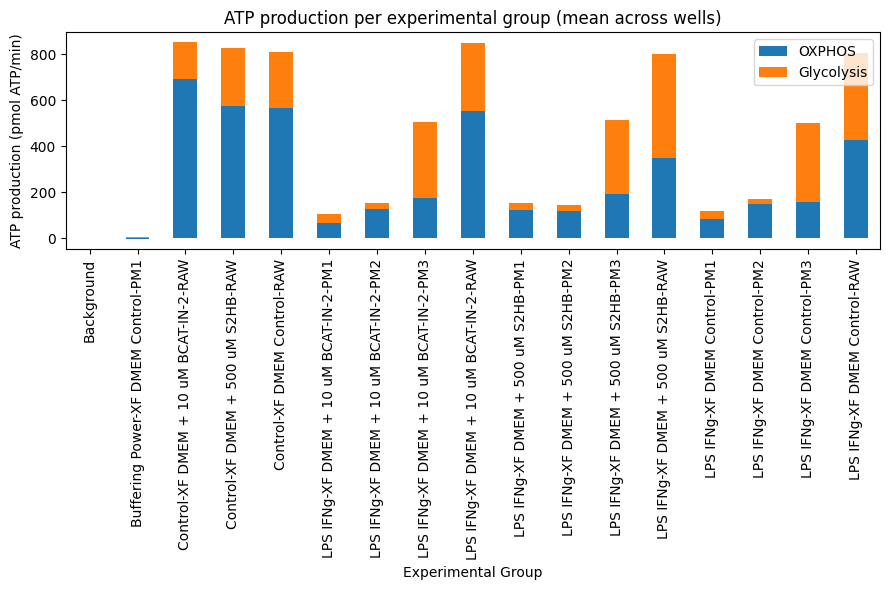

In [18]:
# Create a stacked bar plot of ATP production by experimental group
# This stacks glycolysis ATP on top of OXPHOS ATP. By default we take the mean across wells in each group;
# change .mean() to .sum() if you prefer total ATP per group.
import matplotlib.pyplot as plt

# Ensure 'atp_results' exists
if 'atp_results' not in globals():
    raise NameError('atp_results DataFrame not found. Run the ATP calculation cells first.')

# Aggregate by group (mean across wells). Replace .mean() with .sum() to get totals per group.
group_stats = atp_results.groupby('Group')[['ATP_Production_OxPhos_pmol_ATP_per_min', 'ATP_Production_Glycolysis_pmol_ATP_per_min']].mean()
# Rename columns for clearer plot labels
group_stats = group_stats.rename(columns={"ATP_Production_OxPhos_pmol_ATP_per_min": "OXPHOS",
                                                "ATP_Production_Glycolysis_pmol_ATP_per_min": "Glycolysis"})

# Plot stacked bar
ax = group_stats.plot(kind='bar', stacked=True, figsize=(9,6), color=['#1f77b4', '#ff7f0e'])
ax.set_ylabel('ATP production (pmol ATP/min)')
ax.set_xlabel('Experimental Group')
ax.set_title('ATP production per experimental group (mean across wells)')
plt.tight_layout()
# Save figure to results directory
plt.savefig(os.path.join(res_dir, 'ATP_production_stacked_by_group.png'))
plt.show()

# Print the underlying numbers used for the plot
